<h1>RESTAURANT SEGMENTATION AND PREDICTION SYSTEM</h1>

**A.PROBLEM STATEMENT:** 

The objective of this case study is to build a recommendation engine to predict what restaurants customers are most likely to order from given the customer location, restaurant information, and the customer order history.

**B.DATA OVERVIEW:**

There are 10,000 customers in the test set. These are the customers you will need to recommend a vendor to. Each customer can order from multiple locations (LOC_NUM).

There are 35,000 customers in the train set. Some of these customers have made orders at at least one of 100 vendors.

There are following datasets which is available to us in this case study.

1. test_customers.csv - customer id’s in the test set.

2. test_locations.csv - latitude and longitude for the different locations of each customer for the test data.

3. train_locations.csv - customer locations details in the train dataset.

4. train_customers.csv - latitude and longitude for the different locations of each customer for the train data.

5. orders.csv - orders that the customers train_customers.csv from made.

6. vendors.csv - vendors that customers can order from and their respective details.

7. VariableDefinitions.txt - Variable definitions for the datasets



**C.STRUCTURE OF FINAL SUBMISSION:**

1. SampleSubmission.csv - is an example of what your submission file should look like.

The order of the rows does not matter, but the names of CID X LOC_NUM X VENDOR must be correct. The column "target" is your prediction.In the target 1 means The customer CID will have highest chance of taking orders from vendor VENDOR, and 0 means, CID will not order at all from VENDOR.

**D. BUSINESS OBJECTIVES AND CONSTRAINTS:**

1. No low-latency requirement.

2. Submitted code must run on the original train, test, and other datasets provided.

**E. PERFORMANCE METRICS:**


The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

**1. Precision :** 

This is an indicator of the number of items correctly identified as positive out of total items identified as positive. 
The formula is given as: TP/(TP+FP)

**2. Recall / Sensitivity / True Positive Rate (TPR)**: This is an indicator of the number of items correctly identified as positive out of total actual positives. The formula is given as: TP/(TP+FN)

**3. F1 Score:** A performance score that combines both precision and recall. It is a harmonic mean of these two variables. 

The formula is given as: 
      2*Recall/(Precision + Recall)


Where:

1. TP=True Positive
2. FP=False Positive
3. TN=True Negative
4. FN=False Negative




---


---



## 1.DATA UPLOADING AND MERGING



---



### 1. Importing packages and files

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 3.9MB/s 
     |████████████████████████████████| 15.4MB 449kB/s 
     |████████████████████████████████| 6.6MB 37.0MB/s 


In [ ]:
!pip install -U nltk
!pip install plotly

     |████████████████████████████████| 1.5MB 4.0MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from shapely.geometry import Point,Polygon
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [ ]:
orders=pd.read_csv('orders.csv')
tr_customers=pd.read_csv('train_customers.csv')
tr_locations=pd.read_csv('train_locations.csv')
vendors=pd.read_csv('vendors.csv')
sample=pd.read_csv('SampleSubmission.csv')



---



### 2. File analysis

In [ ]:
print('A.The customers data,Top 5 Rows: ')
print('Shape:',tr_customers.shape)
print('='*100)
tr_customers.head(2)

A.The customers data,Top 5 Rows: 
Shape: (34674, 8)


akeed_customer_id gender  dob  status  verified language  \
0           TCHWPBT   Male  NaN       1         1       EN   
1           ZGFSYCZ   Male  NaN       1         1       EN   

            created_at           updated_at  
0  2018-02-07 19:16:23  2018-02-07 19:16:23  
1  2018-02-09 12:04:42  2018-02-09 12:04:41

In [ ]:
#Preprocessing and removing non-important columns

tr_customers.drop(['dob','created_at','updated_at'], axis=1,inplace=True)
tr_customers.head(2)

akeed_customer_id gender  status  verified language
0           TCHWPBT   Male       1         1       EN
1           ZGFSYCZ   Male       1         1       EN

In [ ]:
gendor=pd.DataFrame()
gendor['customer_id']=tr_customers['akeed_customer_id']
gendor['gendor']=tr_customers['gender']

In [ ]:
print('B.The customers Locations ,Top 5 Rows: ')
print('='*100)
tr_locations.head(5)

B.The customers Locations ,Top 5 Rows: 


customer_id  location_number location_type  latitude  longitude
0     02SFNJH                0           NaN  1.682392 -78.789737
1     02SFNJH                1           NaN  1.679137   0.766823
2     02SFNJH                2           NaN -0.498648   0.661241
3     RU43CXC                0          Home  0.100853   0.438165
4     BDFBPRD                0           NaN  2.523125   0.733464

In [ ]:
#Preprocessing and removing non-important columns

tr_locations.drop(['location_type'], axis=1,inplace=True)
tr_locations.head(2)

customer_id  location_number  latitude  longitude
0     02SFNJH                0  1.682392 -78.789737
1     02SFNJH                1  1.679137   0.766823

In [ ]:
print('Total Orders ,Top 5 Rows: ')
print('='*100)
orders.head(2)

Total Orders ,Top 5 Rows: 


akeed_order_id customer_id  item_count  grand_total  payment_mode  \
0        163238.0     92PEE24         1.0          7.6             2   
1        163240.0     QS68UD8         1.0          8.7             1   

  promo_code  vendor_discount_amount  promo_code_discount_percentage  \
0        NaN                     0.0                             NaN   
1        NaN                     0.0                             NaN   

  is_favorite is_rated  ...  driver_accepted_time  ready_for_pickup_time  \
0         NaN       No  ...                   NaN                    NaN   
1         NaN       No  ...                   NaN                    NaN   

   picked_up_time  delivered_time        delivery_date vendor_id  \
0             NaN             NaN  2019-07-31 05:30:00       105   
1             NaN             NaN  2019-07-31 05:30:00       294   

            created_at LOCATION_NUMBER LOCATION_TYPE CID X LOC_NUM X VENDOR  
0  2019-08-01 05:30:16               0           NaN      92PEE24 X 0 X 105  
1  2019-08-01 05:31:10               0          Work      QS68UD8 X 0 X 294  

[2 rows x 26 columns]

In [ ]:
#Preprocessing and removing non-important columns

orders.drop(['akeed_order_id','promo_code','promo_code_discount_percentage','delivery_date','created_at'], axis=1,inplace=True)
orders.head(2)

customer_id  item_count  grand_total  payment_mode  vendor_discount_amount  \
0     92PEE24         1.0          7.6             2                     0.0   
1     QS68UD8         1.0          8.7             1                     0.0   

  is_favorite is_rated  vendor_rating  driver_rating  deliverydistance  ...  \
0         NaN       No            NaN            0.0               0.0  ...   
1         NaN       No            NaN            0.0               0.0  ...   

   delivery_time order_accepted_time driver_accepted_time  \
0            NaN                 NaN                  NaN   
1            NaN                 NaN                  NaN   

  ready_for_pickup_time picked_up_time delivered_time vendor_id  \
0                   NaN            NaN            NaN       105   
1                   NaN            NaN            NaN       294   

   LOCATION_NUMBER  LOCATION_TYPE CID X LOC_NUM X VENDOR  
0                0            NaN      92PEE24 X 0 X 105  
1                0           Work      QS68UD8 X 0 X 294  

[2 rows x 21 columns]

In [ ]:
print('D. Total Vendors ,Top 5 Rows: ')
print('='*100)

vendors['vendor_id']=vendors['id']
vendors.head(2)

D. Total Vendors ,Top 5 Rows: 


id  authentication_id  latitude  longitude vendor_category_en  \
0   4           118597.0 -0.588596   0.754434        Restaurants   
1  13           118608.0 -0.471654   0.744470        Restaurants   

   vendor_category_id  delivery_charge  serving_distance  is_open  \
0                 2.0              0.0               6.0      1.0   
1                 2.0              0.7               5.0      1.0   

       OpeningTime  ...                 vendor_tag  \
0  11:00AM-11:30PM  ...  2,4,5,8,91,22,12,24,16,23   
1  08:30AM-10:30PM  ...  4,41,51,34,27,15,24,16,28   

                                     vendor_tag_name  one_click_vendor  \
0  Arabic,Breakfast,Burgers,Desserts,Free Deliver...                 Y   
1  Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...                 Y   

  country_id  city_id           created_at           updated_at  device_type  \
0        1.0      1.0  2018-01-30 14:42:04  2020-04-07 15:12:43            3   
1        1.0      1.0  2018-05-03 12:32:06  2020-04-05 20:46:03            3   

  display_orders  vendor_id  
0              1          4  
1              1         13  

[2 rows x 60 columns]



---



In [ ]:
#creating the final table after
final_df=pd.DataFrame()

final_df['customer_id']=orders['customer_id']
final_df['location_number']=orders['LOCATION_NUMBER']
final_df['vendor_id']=orders['vendor_id']

final_df=pd.merge(final_df,tr_locations,how="outer",on=['customer_id','location_number'])
final_df=pd.merge(final_df,gendor,how='outer',on=['customer_id'])

In [ ]:
#dropping unnecessary columns
final_df.drop_duplicates(inplace=True)
final_df['cus_lat']=final_df['latitude']
final_df['cus_long']=final_df['longitude']
final_df.drop(['latitude','longitude'],axis=1,inplace=True)

In [ ]:
final=pd.merge(final_df,vendors,how="outer",on=['vendor_id'])
final.drop_duplicates(inplace=True)
final=final[['customer_id','location_number','gendor','vendor_id','cus_lat','cus_long',\
             'latitude','longitude','vendor_category_en','delivery_charge','serving_distance','is_open',\
             'prepration_time','is_akeed_delivering','vendor_rating','one_click_vendor']]

In [ ]:
#files saved to again reuse it for exploratory data analysis
final.to_csv('final.csv',index=False)



---



## 2.EXPLORATORY DATA ANALYSIS

In [ ]:
#loading the final data file
final=pd.read_csv('final.csv')

In [ ]:
final.head(5)

customer_id  location_number gendor  vendor_id   cus_lat   cus_long  \
0     92PEE24                0   Male      105.0 -0.132100 -78.575297   
1     92PEE24                1   Male      105.0 -0.760509 -78.501031   
2     I9DNSMJ                0   Male      105.0 -1.801505 -78.378004   
3     I9DNSMJ                2   Male      105.0 -1.803343  -0.004722   
4     QQEWRHI                0   Male      105.0  0.027163 -78.594119   

   latitude  longitude vendor_category_en  delivery_charge  serving_distance  \
0 -0.967769   0.080839        Restaurants              0.0              15.0   
1 -0.967769   0.080839        Restaurants              0.0              15.0   
2 -0.967769   0.080839        Restaurants              0.0              15.0   
3 -0.967769   0.080839        Restaurants              0.0              15.0   
4 -0.967769   0.080839        Restaurants              0.0              15.0   

   is_open  prepration_time is_akeed_delivering  vendor_rating  \
0      1.0             12.0                 Yes            4.5   
1      1.0             12.0                 Yes            4.5   
2      1.0             12.0                 Yes            4.5   
3      1.0             12.0                 Yes            4.5   
4      1.0             12.0                 Yes            4.5   

  one_click_vendor  
0                Y  
1                Y  
2                Y  
3                Y  
4                Y

In [ ]:
print('Shape of data:',final.shape)
print('='*100)
print('Columns in data:',final.columns)

Shape of data: (96020, 16)
Columns in data: Index(['customer_id', 'location_number', 'gendor', 'vendor_id', 'cus_lat',
       'cus_long', 'latitude', 'longitude', 'vendor_category_en',
       'delivery_charge', 'serving_distance', 'is_open', 'prepration_time',
       'is_akeed_delivering', 'vendor_rating', 'one_click_vendor'],
      dtype='object')


A. ANALYSIS ON VENDOR ID's

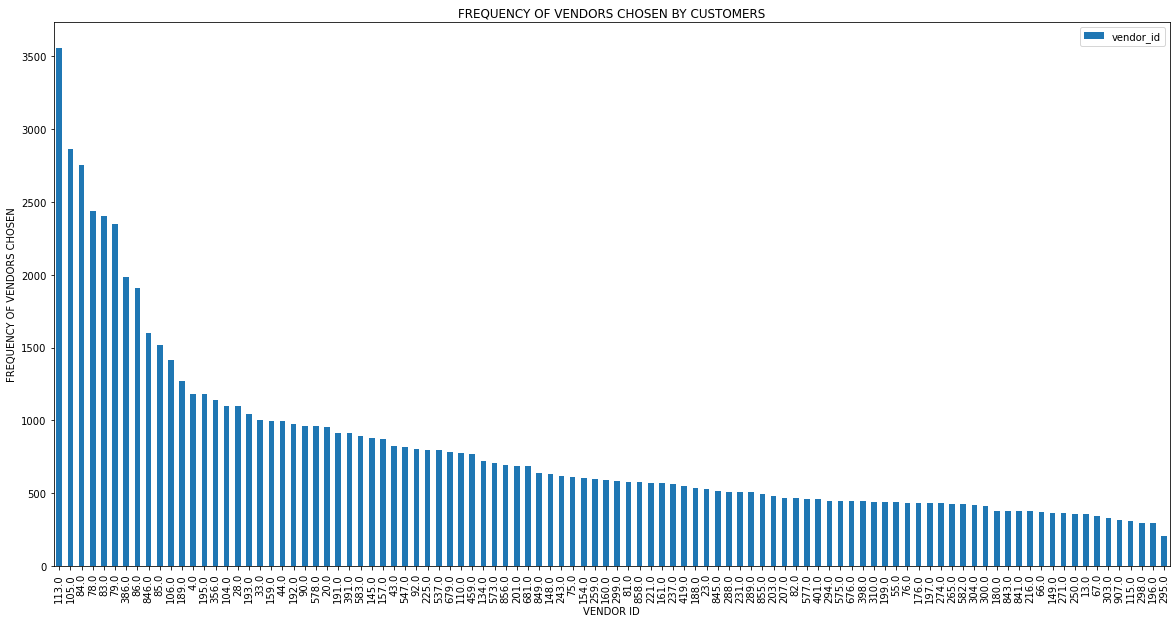

In [ ]:
fig, ax = plt.subplots()
final['vendor_id'].value_counts().plot(ax=ax, kind='bar',figsize=(20, 10))

plt.xlabel('VENDOR ID') 
plt.ylabel('FREQUENCY OF VENDORS CHOSEN') 
plt.title("FREQUENCY OF VENDORS CHOSEN BY CUSTOMERS")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---



1.Here the bar plot showing frequencies of vendors chosen by customers in total period.

2.We can see vendors such as 113,105,84,79,368,86 and 846 contains 25 percentile of total vendors chosen.

3.In recommendation these vendors will have a high chance of being recommended by customers.



---



### 1.Univariate analysis

<h3>A. LOCATIONS OF CUSTOMERS-USING LONGITUDES AND LATITUDES</h3>

In [ ]:
#creating a datframe to analyze customers and vendors locations over map

location_cust=pd.DataFrame()
location_cust['longitude']=final['cus_long']
location_cust['latitude']=final['cus_lat']
location_cust['vendor']=final['vendor_id']
location_cust['ven_lat']=final['latitude']
location_cust['ven_lon']=final['longitude']

#dropping locations with anomalies and using coordinated between (-90,90) for latitudes and (-180,180) for longitudes
location_cust.drop(location_cust.loc[location_cust['latitude']<-90].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['latitude']>90].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['longitude']<-180].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['longitude']>180].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['ven_lat']<-90].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['ven_lat']>90].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['ven_lon']<-180].index, inplace=True)
location_cust.drop(location_cust.loc[location_cust['ven_lon']>180].index, inplace=True)

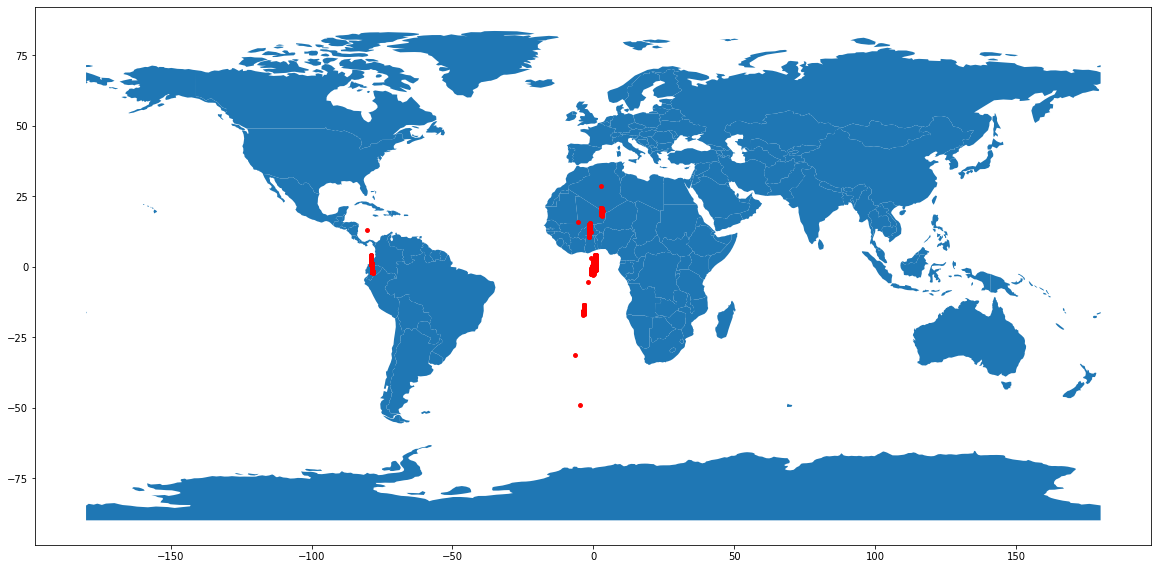

In [ ]:
#plotting locations of customers over map who ordered anything
#source: geopandas documentations

geo=[Point(x) for x in zip(location_cust['longitude'], location_cust['latitude'])]
gdf=gpd.GeoDataFrame(location_cust, geometry=geo)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20,20)), marker='o', color='red', markersize=15);

PLOT DESCRIPTION AND OBSERVATIONS:


---



1.Here the locations of all customers who ordered something are shown.

2.There were around 5000 wrong latitudes and longitudes I found and removed them to get shape in the world map(lat:(-90,90) long:(-180,180)). Still some locations are from sea.

3.Most of the customers are from africa and little percentage from south america.

4.This indicates that using just only locations will not be a much use in our recommendation process. We have to see the vendors locations as well.



---



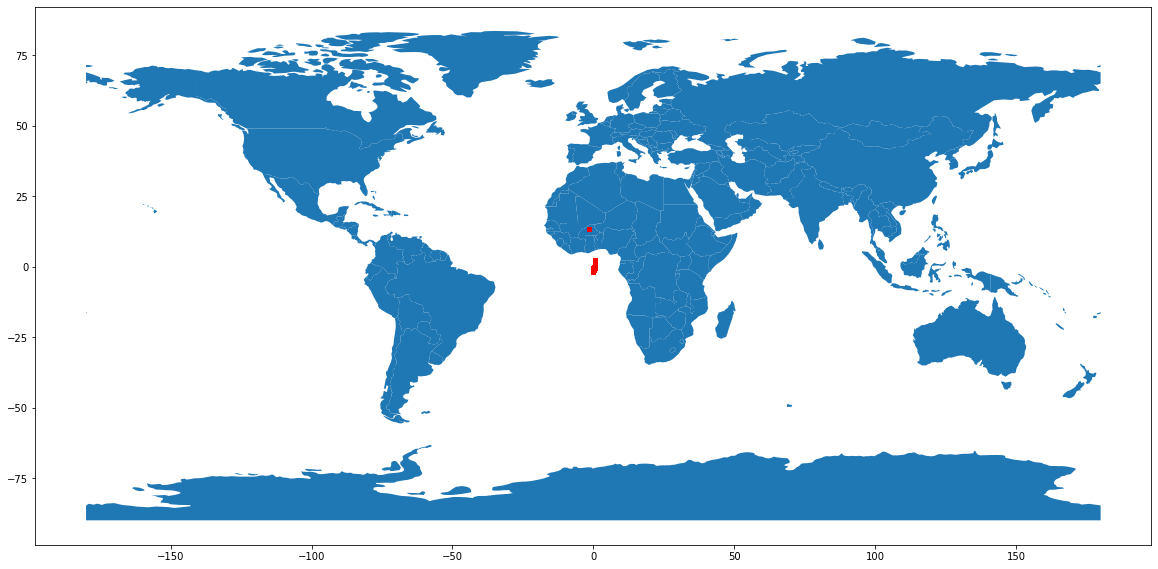

In [ ]:
#plotting locations of vendors over map who received orders
#source: https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db

geo=[Point(x) for x in zip(location_cust['ven_lon'], location_cust['ven_lat'])]
gdf=gpd.GeoDataFrame(location_cust, geometry=geo)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20,20)), marker='o', color='red', markersize=15);

PLOT DESCRIPTION AND OBSERVATIONS:


---



1.Here the locations of all vendors who received order from out of all customers.

2.There were around 1000 wrong latitudes and longitudes I found and removed them to get shape in the world map(lat:(-90,90) long:(-180,180)). Still some locations are from sea.

3.All the vendors are from africa, but as we can see using these longitudes and latitudes, finding recommendations are tough. We have to see distance between customers and vendors locations in next approaches.



---



<h3>B. DISTANCE BETWEEN VENDORS AND CUSTOMERS </h3>

In [ ]:
!pip install geopy

     |████████████████████████████████| 112 kB 2.8 MB/s eta 0:00:01


In [ ]:
#using these coordinates we can find distances between all vendors
import geopy.distance
#snippet of code reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

dis=[]
location_cust.dropna(inplace=True)
for i in location_cust.values:

  coords_1 = (i[0],i[1])
  coords_2 = (i[3],i[4])
  dis.append(geopy.distance.geodesic(coords_1, coords_2).km)

location_cust['distance']=dis
location_cust.head(2)

longitude  latitude  vendor   ven_lat   ven_lon                  geometry  \
0 -78.575297 -0.132100   105.0 -0.967769  0.080839  POINT (0.08084 -0.96777)   
1 -78.501031 -0.760509   105.0 -0.967769  0.080839  POINT (0.08084 -0.96777)   

      distance  
0  8619.063288  
1  8610.903479

<AxesSubplot:xlabel='distance'>

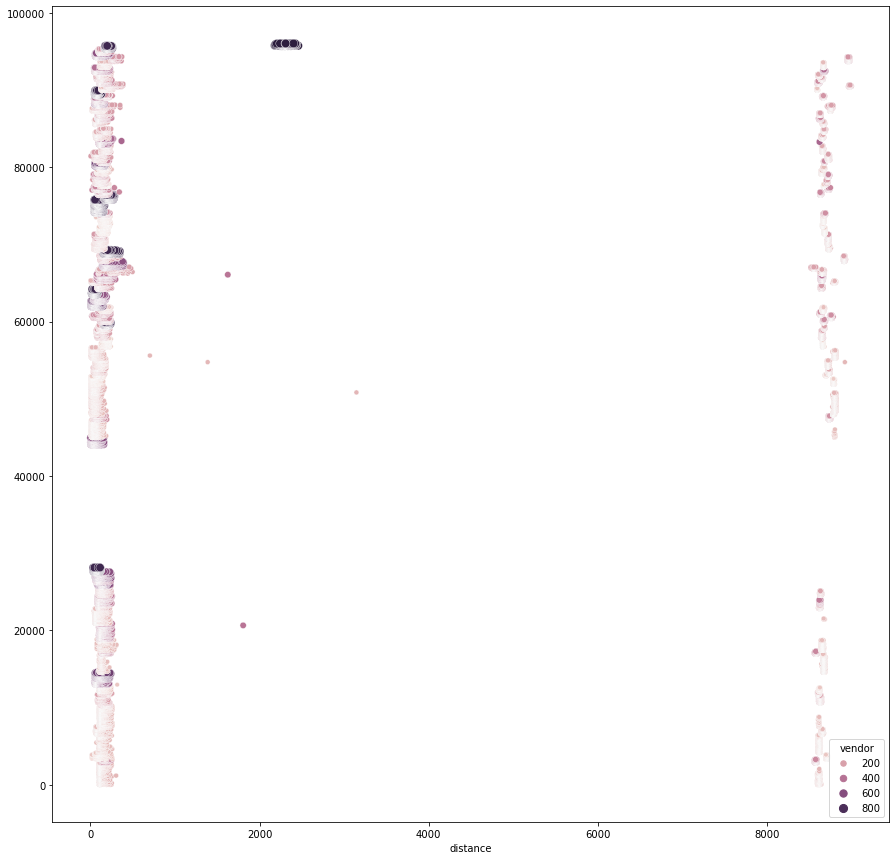

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(data=location_cust, x="distance", y=location_cust.index,hue='vendor',size="vendor")

PLOT DESCRIPTION AND OBSERVATIONS:


---



1.Here the distances between the vendors and customers are shown using a seaborn plot.

2.There are 2 seperate regions in this, first those ordered from south america whose distances are around 8000 Kms and second who ordered from africa whose distances are under 500 km. Also vendor with id's less than 200 are most favorites.

3.So distance is a feature that drives customers to order, so customers prefer ordering fro vendors in 500 km range most in africa and when you are in south america it is in range 8000km.

4.But why people having distance of more than 8000 are shown, because travelling to a different continent for restaurant is quite different.

---



<h3>C. VENDOR CATEGORIES</h3>

In [ ]:
final.head(2)

customer_id  location_number gendor  vendor_id   cus_lat   cus_long  \
0     92PEE24                0   Male      105.0 -0.132100 -78.575297   
1     92PEE24                1   Male      105.0 -0.760509 -78.501031   

   latitude  longitude vendor_category_en  delivery_charge  serving_distance  \
0 -0.967769   0.080839        Restaurants              0.0              15.0   
1 -0.967769   0.080839        Restaurants              0.0              15.0   

   is_open  prepration_time is_akeed_delivering  vendor_rating  \
0      1.0             12.0                 Yes            4.5   
1      1.0             12.0                 Yes            4.5   

  one_click_vendor  
0                Y  
1                Y

In [ ]:
final['vendor_category_en'].value_counts()
#there are only 2 categories seen and most of them were restaurants

Restaurants       70854
Sweets & Bakes     9301
Name: vendor_category_en, dtype: int64

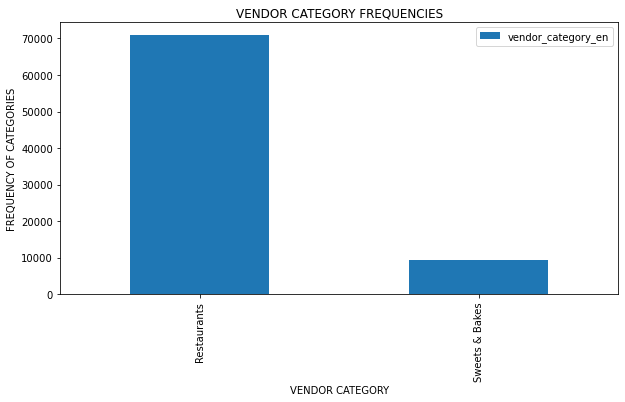

In [ ]:
fig, ax = plt.subplots()
final['vendor_category_en'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('VENDOR CATEGORY') 
plt.ylabel('FREQUENCY OF CATEGORIES') 
plt.title("VENDOR CATEGORY FREQUENCIES")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---



1.Here is the plot of frequencies of vendor_categories

2.There are only 2 broad categories. restaurants and sweets and bakes.

3.Most vendors are from restaurant category and 20k are from sweets and bakes.category is not a much important feature for recommendation it seems.



---



<h3>D. DELIVERY CHARGES ANALYSIS</h3>

In [ ]:
final.head(2)

customer_id  location_number gendor  vendor_id   cus_lat   cus_long  \
0     92PEE24                0   Male      105.0 -0.132100 -78.575297   
1     92PEE24                1   Male      105.0 -0.760509 -78.501031   

   latitude  longitude vendor_category_en  delivery_charge  serving_distance  \
0 -0.967769   0.080839        Restaurants              0.0              15.0   
1 -0.967769   0.080839        Restaurants              0.0              15.0   

   is_open  prepration_time is_akeed_delivering  vendor_rating  \
0      1.0             12.0                 Yes            4.5   
1      1.0             12.0                 Yes            4.5   

  one_click_vendor  
0                Y  
1                Y

In [ ]:
final['delivery_charge'].value_counts()

0.0    40369
0.7    39786
Name: delivery_charge, dtype: int64

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.From the data we can see that in the presense of delivery charge (0.7) and no delivery charge (0.0), there are same numbers of orders and it dosen't affect the orders.

2.This feature is not important for us in this recommendation.


---



<h3>E. VENDOR RATINGS</h3>

In [ ]:
final['vendor_rating'].value_counts()

4.5    17809
4.3    14867
4.2    11784
4.4    11102
4.7     7471
4.6     7462
4.1     3786
4.0     2854
3.8      959
3.2      880
4.8      750
3.7      431
Name: vendor_rating, dtype: int64

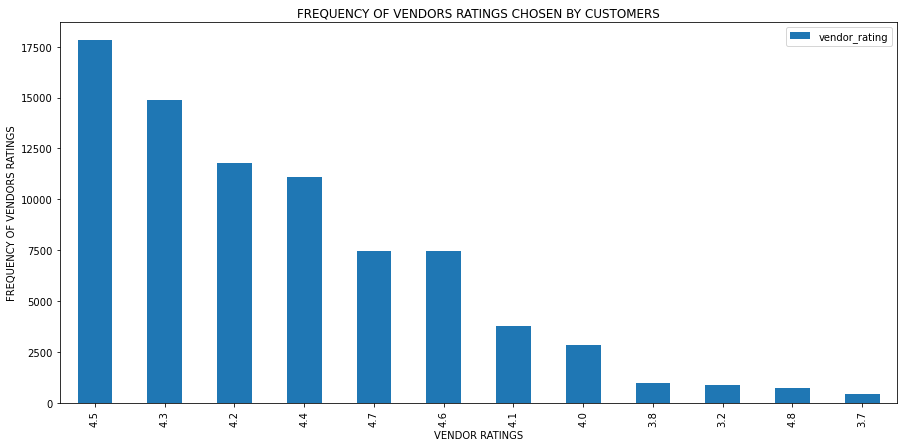

In [ ]:
fig, ax = plt.subplots()
final['vendor_rating'].value_counts().plot(ax=ax, kind='bar',figsize=(15, 7))

plt.xlabel('VENDOR RATINGS') 
plt.ylabel('FREQUENCY OF VENDORS RATINGS') 
plt.title("FREQUENCY OF VENDORS RATINGS CHOSEN BY CUSTOMERS")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.We have plotted vendor ratings and their frequencies to find out whether rating can a good feature for recommendation or not.

2.Most of the customers have ordered from the vendors with vendor ratings greater than 4.1.

3.So if ratings are near to 5. chances of ordering is great and that's why rating is very important tool for use.


---



<h3> F. ALL OTHER COLUMNS FREQUENCIES</h3>

In [ ]:
final.head(2)

customer_id  location_number gendor  vendor_id   cus_lat   cus_long  \
0     92PEE24                0   Male      105.0 -0.132100 -78.575297   
1     92PEE24                1   Male      105.0 -0.760509 -78.501031   

   latitude  longitude vendor_category_en  delivery_charge  serving_distance  \
0 -0.967769   0.080839        Restaurants              0.0              15.0   
1 -0.967769   0.080839        Restaurants              0.0              15.0   

   is_open  prepration_time is_akeed_delivering  vendor_rating  \
0      1.0             12.0                 Yes            4.5   
1      1.0             12.0                 Yes            4.5   

  one_click_vendor  
0                Y  
1                Y

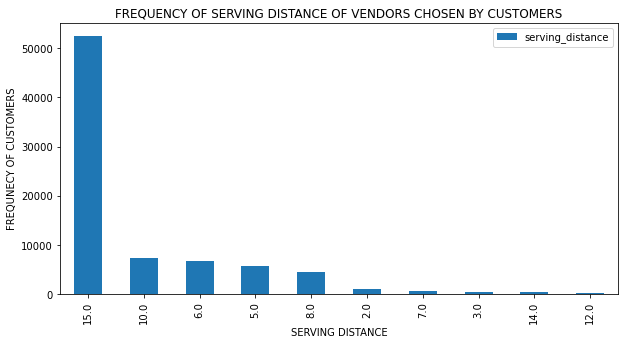

In [ ]:
fig, ax = plt.subplots()
final['serving_distance'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('SERVING DISTANCE') 
plt.ylabel('FREQUNECY OF CUSTOMERS') 
plt.title("FREQUENCY OF SERVING DISTANCE OF VENDORS CHOSEN BY CUSTOMERS")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.We have plotted vendors serving distanec to find if their serving distance affects the chances or getting orders or not.

2.We got to know that if the vendor has a serving distance of 15, chances are high that the customer will have an order from this.

3.Hence this feature is useful for our recommendation.


---



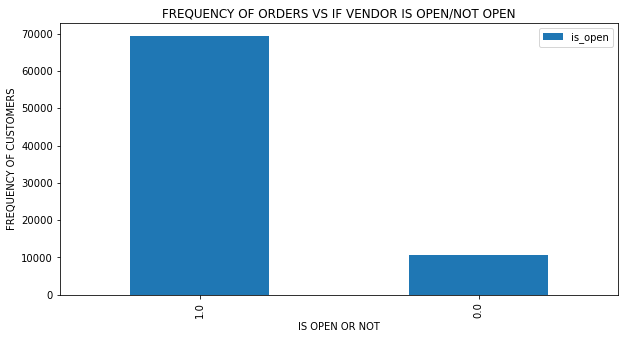

In [ ]:
fig, ax = plt.subplots()
final['is_open'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('IS OPEN OR NOT') 
plt.ylabel('FREQUENCY OF CUSTOMERS') 
plt.title("FREQUENCY OF ORDERS VS IF VENDOR IS OPEN/NOT OPEN")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---

1.We have plotted is_open scatter plot to see if status of vendors affects the chance of getting orders or not.

1.From the data we can see that if it's open then high chance is there but even if it is not open, there are 10000 orders made, that is quite an anomaly.

2.Hence this feature is useful to some extent for our recommendations.


---



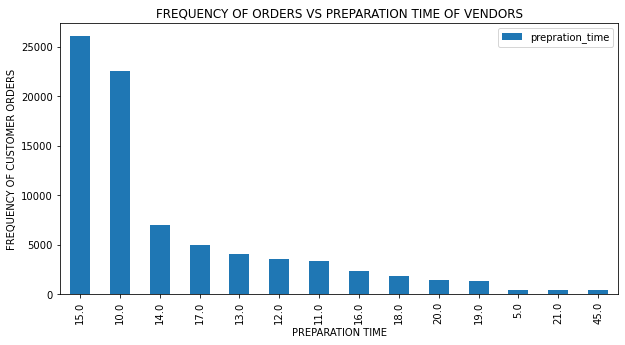

In [ ]:
fig, ax = plt.subplots()
final['prepration_time'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('PREPARATION TIME') 
plt.ylabel('FREQUENCY OF CUSTOMER ORDERS') 
plt.title("FREQUENCY OF ORDERS VS PREPARATION TIME OF VENDORS")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---

1.We have plotted preparation_time to check if time for preparation is a useful feature or not.

2.We can see that standard time 10 and 15 mins are highly appreciated but also if the time is under 5, there are less orders. So it can depend on orders and type of orders.

3.So this feature can be useful if and if only type of orders taken into account otherwise confusing.


---



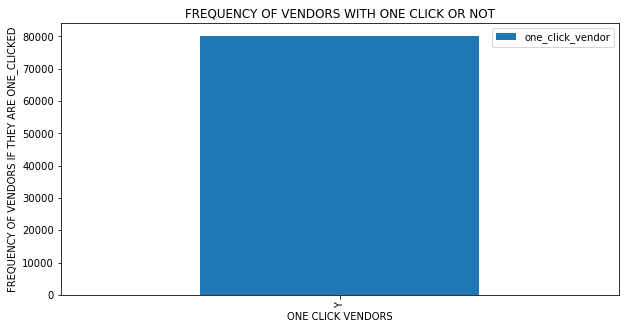

In [ ]:
fig, ax = plt.subplots()
final['one_click_vendor'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('ONE CLICK VENDORS') 
plt.ylabel('FREQUENCY OF VENDORS IF THEY ARE ONE_CLICKED') 
plt.title("FREQUENCY OF VENDORS WITH ONE CLICK OR NOT")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.We have plotted whether one_click_vendor to check if vendor is one click process vendor or not that is chosen by customers.

2.All all the customers have chosen vendors with one_click service enables, this feature is not useful for our recommendation.


---



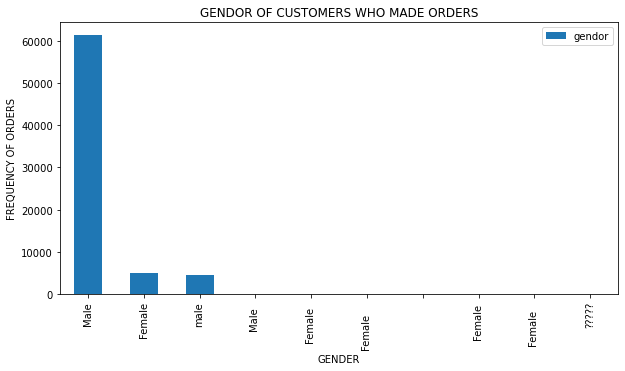

In [ ]:
fig, ax = plt.subplots()
final['gendor'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('GENDER') 
plt.ylabel('FREQUENCY OF ORDERS') 
plt.title("GENDOR OF CUSTOMERS WHO MADE ORDERS")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---

1.We have plotted gender of customers vs their frequency of orders.

2.As we can see there are 70k, around 80% of the customers as male and 10k as female. This can be a good feature but not to great extent.

---



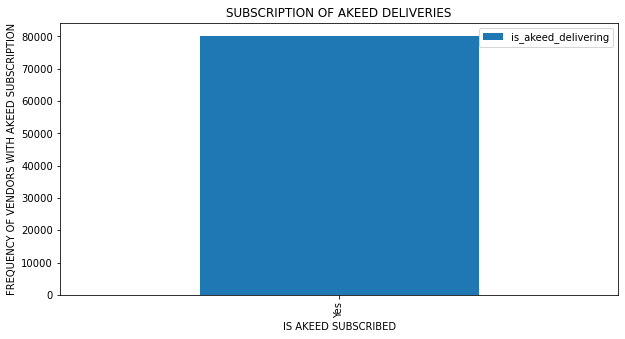

In [ ]:
fig, ax = plt.subplots()
final['is_akeed_delivering'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5))

plt.xlabel('IS AKEED SUBSCRIBED') 
plt.ylabel('FREQUENCY OF VENDORS WITH AKEED SUBSCRIPTION') 
plt.title("SUBSCRIPTION OF AKEED DELIVERIES")

ax.legend()

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.We have plotted whether is_akeed_delivering to check if vendor is subscribed to akeed.

2.As all the vendors are subscribed, this feature will not affect the recommendation.


---



### 2.Bivariate analysis

<h3>A. VENDOR VS DISTANCE BETWEEN CUSTOMER AND VENDOR</h3>

In [ ]:
#reading file 
final=pd.read_csv('final.csv')
final.head(2)

customer_id  location_number gendor  vendor_id   cus_lat   cus_long  \
0     92PEE24                0   Male      105.0 -0.132100 -78.575297   
1     92PEE24                1   Male      105.0 -0.760509 -78.501031   

   latitude  longitude vendor_category_en  delivery_charge  serving_distance  \
0 -0.967769   0.080839        Restaurants              0.0              15.0   
1 -0.967769   0.080839        Restaurants              0.0              15.0   

   is_open  prepration_time is_akeed_delivering  vendor_rating  \
0      1.0             12.0                 Yes            4.5   
1      1.0             12.0                 Yes            4.5   

  one_click_vendor  
0                Y  
1                Y

<AxesSubplot:xlabel='distance', ylabel='vendor'>

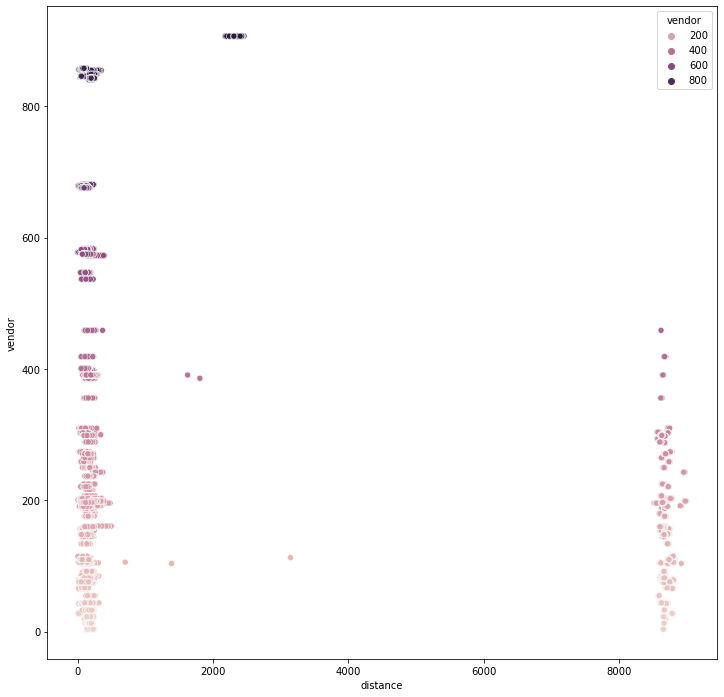

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=location_cust, x="distance", y='vendor',hue='vendor')

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.I have plotted distance vs vendor chosen by customers. This distance is between the customers(Home or work etc) and the vendor location.

2.This graph shows different clusters and also cluters than are at 2000kms, Here there are 2 different regions, first is people living in south america and second one in left are people living in africa.

3.Here we can conclude that vendor with id's less than 200 are more favorite for people in south america and for people in africa, there is no such bond.

4.Also distance is a very useful feature to recommend the vendor.


---



<h3>B.VENDOR_RATING VS CUSTOMERS</h3>

<AxesSubplot:xlabel='vendor_id', ylabel='vendor_rating'>

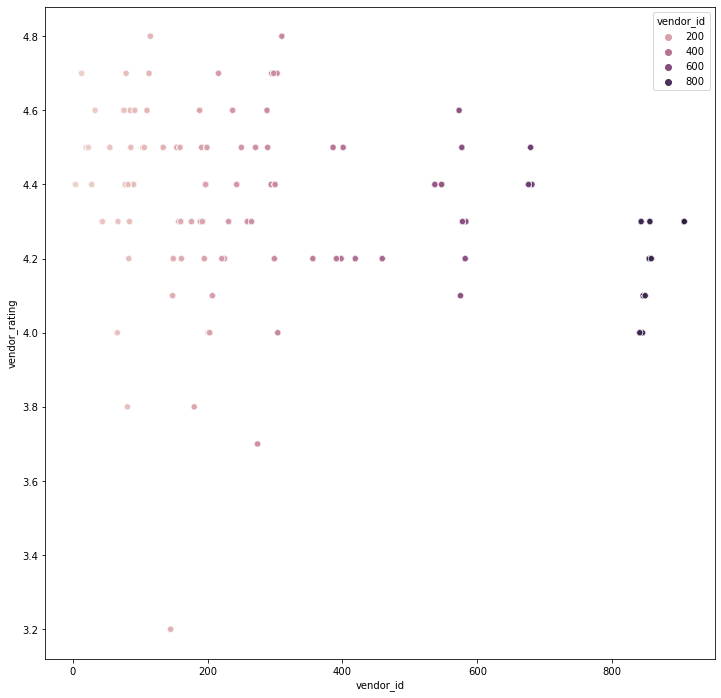

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=final, x="vendor_id", y='vendor_rating',hue='vendor_id')

PLOT DESCRIPTION AND OBSERVATIONS:


---


1.I have plotted ratings vs vendor chosen by customers.Ratings are of vendors.

2.The range starts from 3.7 to 5 and as close to 5, vendors are more chosen, so this also can be a goof feature for recommendation after distance.

---





---



---



## 3.FEATURE ENGINEERING

### A. Checking Imputations

In [ ]:
data=pd.read_csv('train.csv')

In [ ]:
data.head()

customer_id gender  status_x  verified_x         created_at_x  \
0     TCHWPBT   Male         1           1  2018-02-07 19:16:23   
1     TCHWPBT   Male         1           1  2018-02-07 19:16:23   
2     TCHWPBT   Male         1           1  2018-02-07 19:16:23   
3     TCHWPBT   Male         1           1  2018-02-07 19:16:23   
4     TCHWPBT   Male         1           1  2018-02-07 19:16:23   

          updated_at_x  location_number location_type  latitude_x  \
0  2018-02-07 19:16:23                0          Work      -96.44   
1  2018-02-07 19:16:23                0          Work      -96.44   
2  2018-02-07 19:16:23                0          Work      -96.44   
3  2018-02-07 19:16:23                0          Work      -96.44   
4  2018-02-07 19:16:23                0          Work      -96.44   

   longitude_x  ...  country_id  city_id         created_at_y  \
0        -67.2  ...         1.0      1.0  2018-01-30 14:42:04   
1        -67.2  ...         1.0      1.0  2018-05-03 12:32:06   
2        -67.2  ...         1.0      1.0  2018-05-04 22:28:22   
3        -67.2  ...         1.0      1.0  2018-05-06 19:20:48   
4        -67.2  ...         1.0      1.0  2018-05-17 22:12:38   

          updated_at_y device_type  display_orders  location_number_obj  \
0  2020-04-07 15:12:43           3               1                    0   
1  2020-04-05 20:46:03           3               1                    0   
2  2020-04-07 16:35:55           3               1                    0   
3  2020-04-02 00:56:17           3               1                    0   
4  2020-04-05 15:57:41           3               1                    0   

   id_obj  CID X LOC_NUM X VENDOR target  
0       4         TCHWPBT X 0 X 4      0  
1      13        TCHWPBT X 0 X 13      0  
2      20        TCHWPBT X 0 X 20      0  
3      23        TCHWPBT X 0 X 23      0  
4      28        TCHWPBT X 0 X 28      0  

[5 rows x 73 columns]

In [ ]:
#removing columns that are not important and relatable

train_df=data[['customer_id','gender','location_number','location_type','latitude_x',\
           'longitude_x','id','latitude_y','longitude_y','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating',\
           'CID X LOC_NUM X VENDOR','target']]

In [ ]:
train_df.head(2)

customer_id gender  location_number location_type  latitude_x  longitude_x  \
0     TCHWPBT   Male                0          Work      -96.44        -67.2   
1     TCHWPBT   Male                0          Work      -96.44        -67.2   

   id  latitude_y  longitude_y vendor_category_en  delivery_charge  \
0   4     -0.5884       0.7544        Restaurants              0.0   
1  13     -0.4717       0.7446        Restaurants              0.7   

   serving_distance  is_open  prepration_time  vendor_rating  \
0               6.0      1.0               15            4.4   
1               5.0      1.0               14            4.7   

  CID X LOC_NUM X VENDOR  target  
0        TCHWPBT X 0 X 4       0  
1       TCHWPBT X 0 X 13       0

In [ ]:
#Here train_df['target'] contains 1-If the particular  (CID X LOC_NUM X VENDOR) customer with location number has ordered .
#0- if the particular customer with location number has not ordered

In [ ]:
#shape of final train dataset for featurization

train_df.shape

(5802400, 17)

In [ ]:
#First we will remove those columns which contains more than 25% of null values:
train_df = train_df[train_df.columns[train_df.isnull().mean() < (1-0.25)]]
#So there was no column that contained more than 25% of null values
train_df.shape

(5802400, 17)

In [ ]:
#We will remove all rows by checking null values column wise, that is to be greater than 70 to stay,Otherwise will be removed.

train_df=train_df.loc[train_df.isnull().mean(axis=1) < (1-0.3)]

#similarly all rows are also correct will less null values
train_df.shape

(5802400, 17)

In [ ]:
# If there are missing values, We will impute it with medians
train_df = train_df.fillna(train_df.median())

### B. Visualization of outliers and removal

<AxesSubplot:xlabel='latitude_x'>

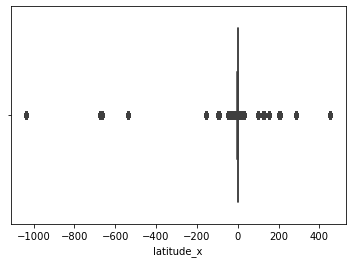

In [ ]:
#reference blog: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
#Box plot to detect outliers

sns.boxplot(x=train_df['latitude_x'])

<AxesSubplot:xlabel='latitude_y'>

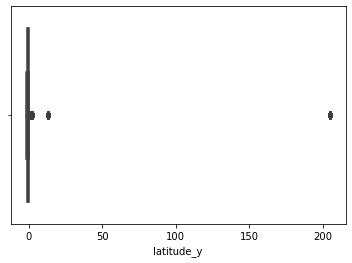

In [ ]:
sns.boxplot(x=train_df['latitude_y'])

<AxesSubplot:xlabel='longitude_x'>

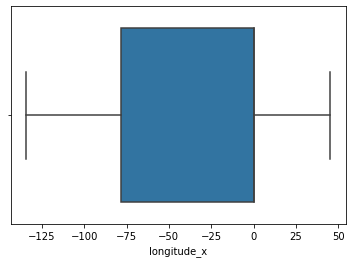

In [ ]:
sns.boxplot(x=train_df['longitude_x'])

<AxesSubplot:xlabel='longitude_y'>

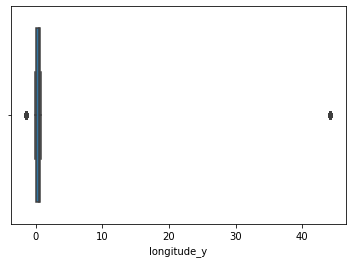

In [ ]:
sns.boxplot(x=train_df['longitude_y'])

In [ ]:
#hence we will remove the customers,vendors with wrong latitude and longitude
#The range is from -90 to 90 for latitude and -180 to 180 for longitude.

checked = train_df[(train_df['latitude_x'] < 90) & (train_df['latitude_x'] > -90)]
checked1 = checked[(checked['latitude_y'] < 90) & (checked['latitude_y'] > -90)]
checked2 = checked1[(checked1['longitude_x'] < 180) & (checked1['longitude_x'] > -180)]
train_df = checked2[(checked2['longitude_y'] < 180) & (checked2['longitude_y'] > -180)]

#print final_shape
train_df.shape

(5616765, 17)

In [ ]:
#saving to start from here
train_df.to_csv('train_data.csv',index=False)

In [ ]:
train_df=pd.read_csv('train_data.csv')

In [ ]:
train_df.describe()

location_number    latitude_x   longitude_x            id  \
count     5.616765e+06  5.616765e+06  5.616765e+06  5.616765e+06   
mean      7.499956e-01  2.009753e-01 -2.550200e+01  2.894242e+02   
std       1.297298e+00  2.742297e+00  3.701066e+01  2.422296e+02   
min       0.000000e+00 -4.903000e+01 -8.010000e+01  4.000000e+00   
25%       0.000000e+00 -5.073000e-01 -7.850000e+01  1.050000e+02   
50%       0.000000e+00 -9.520000e-02  3.160000e-02  2.010000e+02   
75%       1.000000e+00  2.167000e-01  5.160000e-01  3.910000e+02   
max       2.600000e+01  2.873000e+01  3.285000e+00  9.070000e+02   

         latitude_y   longitude_y  delivery_charge  serving_distance  \
count  5.616765e+06  5.616765e+06     5.616765e+06      5.616765e+06   
mean  -1.786967e-01  3.652483e-01     4.101010e-01      1.176768e+01   
std    1.554850e+00  3.417692e-01     3.448012e-01      4.104268e+00   
min   -1.787000e+00 -1.449000e+00     0.000000e+00      2.000000e+00   
25%   -8.154000e-01  8.136000e-02     0.000000e+00      8.000000e+00   
50%   -4.946000e-01  5.270000e-01     7.000000e-01      1.500000e+01   
75%    1.563000e-02  6.445000e-01     7.000000e-01      1.500000e+01   
max    1.333600e+01  7.600000e-01     7.000000e-01      1.500000e+01   

            is_open  prepration_time  vendor_rating        target  
count  5.616765e+06     5.616765e+06   5.616765e+06  5.616765e+06  
mean   8.484848e-01     1.402020e+01   4.350505e+00  1.383323e-02  
std    3.585503e-01     4.315769e+00   2.487844e-01  1.167984e-01  
min    0.000000e+00     5.000000e+00   3.200000e+00  0.000000e+00  
25%    1.000000e+00     1.000000e+01   4.200000e+00  0.000000e+00  
50%    1.000000e+00     1.500000e+01   4.400000e+00  0.000000e+00  
75%    1.000000e+00     1.500000e+01   4.500000e+00  0.000000e+00  
max    1.000000e+00     4.500000e+01   4.800000e+00  1.000000e+00

In [ ]:
train_df.head(2)

customer_id gender  location_number location_type  latitude_x  longitude_x  \
0     TCHWPBT   Male                2           NaN     -0.1287       -78.56   
1     TCHWPBT   Male                2           NaN     -0.1287       -78.56   

   id  latitude_y  longitude_y vendor_category_en  delivery_charge  \
0   4     -0.5884       0.7544        Restaurants              0.0   
1  13     -0.4717       0.7446        Restaurants              0.7   

   serving_distance  is_open  prepration_time  vendor_rating  \
0               6.0      1.0               15            4.4   
1               5.0      1.0               14            4.7   

  CID X LOC_NUM X VENDOR  target  
0        TCHWPBT X 2 X 4       0  
1       TCHWPBT X 2 X 13       0

### C. Binning

There are 5 fields in which we can perform binning to get best results without affecting the performance metrics.

These are: 

1.delivery_charge	

2.serving_distance

3.is_open	

4.prepration_time	

5.vendor_rating



---



In [ ]:
train_df['delivery_charge'].value_counts()

0.7    3290630
0.0    2326135
Name: delivery_charge, dtype: int64

In [ ]:
# As there are only 2 categories, I have binned all 0.7 values to 1 and 0.0 values to 0
delivery_charge_en=[]

for i in train_df['delivery_charge'].values:
  if i==0.7:
    delivery_charge_en.append(1)
  else:
    delivery_charge_en.append(0)

train_df['delivery_charge_en']=delivery_charge_en

In [ ]:
train_df['serving_distance'].value_counts()

15.0    3233895
10.0     624085
5.0      567350
6.0      453880
8.0      453880
14.0      56735
3.0       56735
7.0       56735
12.0      56735
2.0       56735
Name: serving_distance, dtype: int64

In [ ]:
# as there are 4 major ranges, 0-6 , 6-10, 10-12 and above 12. I have binned using range for serving distance.

serving_distance_en=[]

for i in train_df['serving_distance'].values:
  if i<=6:
    serving_distance_en.append(1)
  elif 6<i<=10:
    serving_distance_en.append(2)
  elif 10<i<=12:
    serving_distance_en.append(3)
  else:
    serving_distance_en.append(4)

train_df['serving_distance_en']=serving_distance_en

In [ ]:
train_df['is_open'].value_counts()

1.0    4765740
0.0     851025
Name: is_open, dtype: int64

In [ ]:
# As there are only 2 categories, I have binned them into 1-Is_open Yes and 0-Is_open No

is_open_en=[]

for i in train_df['is_open'].values:
  if i==1.0:
    is_open_en.append(1)
  else:
    is_open_en.append(0)

train_df['is_open_en']=is_open_en

In [ ]:
train_df['prepration_time'].value_counts()

15    1985725
10    1418375
14     397145
17     340410
11     283675
13     283675
16     226940
20     170205
12     113470
18     113470
19     113470
5       56735
21      56735
45      56735
Name: prepration_time, dtype: int64

In [ ]:
# We can see there are major 4 categories of bin ranges, 5-10, 10-15,15-20 and above 20

preparation_time_en=[]

for i in train_df['prepration_time'].values:
  if 5<=i<=10:
    preparation_time_en.append(1)
  elif 10<i<=15:
    preparation_time_en.append(2)
  elif 15<i<=20:
    preparation_time_en.append(3)
  else:
    preparation_time_en.append(4)

train_df['preparation_time_en']=preparation_time_en

In [ ]:
train_df['vendor_rating'].value_counts()

4.5    1077965
4.3     964495
4.2     851025
4.4     794290
4.6     567350
4.7     397145
4.0     340410
4.1     283675
4.8     113470
3.8     113470
3.2      56735
3.7      56735
Name: vendor_rating, dtype: int64

In [ ]:
#Here I can see 5 range of ratings and lets bin them like
#(below 3.7)-->1, (3.7-4.0)-->2, (4.0-4.2)-->3, (4.2-4.5)-->4, (4.5 and above)-->5

vendor_rating_en=[]

for i in train_df['vendor_rating'].values:
  if i<=3.7:
    vendor_rating_en.append(1)
  elif 3.7<i<=4.0:
    vendor_rating_en.append(2)
  elif 4.0<i<=4.2:
    vendor_rating_en.append(3)
  elif 4.2<i<=4.5:
    vendor_rating_en.append(4)
  else:
    vendor_rating_en.append(5)

train_df['vendor_rating_en']=vendor_rating_en

In [ ]:
train_df['gender'].value_counts()

Male      3709332
Female     299970
Name: gender, dtype: int64

In [ ]:
# As there are only 2 categories, I have binned them into Male-0 and Female-1

gender_en=[]

for i in train_df['gender'].values:
  if i=='Male':
    gender_en.append(0)
  else:
    gender_en.append(1)

train_df['gender_en']=gender_en

In [ ]:
train_df['vendor_category_en'].value_counts()

Restaurants       4992680
Sweets & Bakes     624085
Name: vendor_category_en, dtype: int64

In [ ]:
# As there are only 2 categories, I have binned them into Restuarants: 1 and Sweets & Bakes: 0

vendor_category=[]

for i in train_df['vendor_category_en'].values:
  if i=='Restaurants':
    vendor_category.append(1)
  else:
    vendor_category.append(0)

train_df['vendor_category']=vendor_category

In [ ]:
# Saving preprocessed file for future use

train_df.to_csv('preprocessed.csv',index=False)



---



In [ ]:
train_df=pd.read_csv('preprocessed.csv')

In [ ]:
train_df.drop(['location_type'],axis=1,inplace=True)
train_df.head()

customer_id gender  location_number  latitude_x  longitude_x  id  \
0     TCHWPBT   Male                2     -0.1287       -78.56   4   
1     TCHWPBT   Male                2     -0.1287       -78.56  13   
2     TCHWPBT   Male                2     -0.1287       -78.56  20   
3     TCHWPBT   Male                2     -0.1287       -78.56  23   
4     TCHWPBT   Male                2     -0.1287       -78.56  28   

   latitude_y  longitude_y vendor_category_en  delivery_charge  ...  \
0     -0.5884       0.7544        Restaurants              0.0  ...   
1     -0.4717       0.7446        Restaurants              0.7  ...   
2     -0.4075       0.6436        Restaurants              0.0  ...   
3     -0.5854       0.7540        Restaurants              0.0  ...   
4      0.4807       0.5527        Restaurants              0.7  ...   

   vendor_rating  CID X LOC_NUM X VENDOR  target  delivery_charge_en  \
0            4.4         TCHWPBT X 2 X 4       0                   0   
1            4.7        TCHWPBT X 2 X 13       0                   1   
2            4.5        TCHWPBT X 2 X 20       0                   0   
3            4.5        TCHWPBT X 2 X 23       0                   0   
4            4.4        TCHWPBT X 2 X 28       0                   1   

  serving_distance_en  is_open_en  preparation_time_en  vendor_rating_en  \
0                   1           1                    2                 4   
1                   1           1                    2                 5   
2                   2           1                    3                 4   
3                   1           1                    3                 4   
4                   4           1                    1                 4   

   gender_en  vendor_category  
0          0                1  
1          0                1  
2          0                1  
3          0                1  
4          0                1  

[5 rows x 23 columns]

### D. Normalization 
    
As all the data has been binned, the need for normalization or scaling of data has beem reduced, Further we will see the feature importance to find out whether our preprocessed columns have been made a difference or not.



---



### E. Feature Importance and Feature Elimination

In [ ]:
corr=train_df[['location_number','gender_en','vendor_category','delivery_charge_en',\
           'serving_distance_en','is_open_en','preparation_time_en','vendor_rating_en','target']]
corr.corr()

location_number     gender_en  vendor_category  \
location_number         1.000000e+00 -1.083937e-01    -1.246404e-14   
gender_en              -1.083937e-01  1.000000e+00     1.594191e-14   
vendor_category        -1.246404e-14  1.594191e-14     1.000000e+00   
delivery_charge_en     -2.060277e-14  3.057348e-14     1.595041e-01   
serving_distance_en    -2.668470e-14  5.140911e-14    -1.074355e-01   
is_open_en             -6.926633e-15 -1.066091e-15     1.195229e-01   
preparation_time_en     2.838429e-14 -4.966859e-14    -1.147250e-01   
vendor_rating_en       -3.357673e-15  2.079870e-14     1.553987e-02   
target                  7.797102e-03 -1.657012e-02     1.751520e-04   

                     delivery_charge_en  serving_distance_en    is_open_en  \
location_number           -2.060277e-14        -2.668470e-14 -6.926633e-15   
gender_en                  3.057348e-14         5.140911e-14 -1.066091e-15   
vendor_category            1.595041e-01        -1.074355e-01  1.195229e-01   
delivery_charge_en         1.000000e+00         1.164292e-01 -1.837113e-01   
serving_distance_en        1.164292e-01         1.000000e+00 -1.628780e-01   
is_open_en                -1.837113e-01        -1.628780e-01  1.000000e+00   
preparation_time_en        1.411852e-01         3.237923e-02 -2.265504e-01   
vendor_rating_en           5.520680e-02        -1.606268e-01  2.609604e-01   
target                    -2.241130e-02         1.651532e-02  5.571070e-03   

                     preparation_time_en  vendor_rating_en    target  
location_number             2.838429e-14     -3.357673e-15  0.007797  
gender_en                  -4.966859e-14      2.079870e-14 -0.016570  
vendor_category            -1.147250e-01      1.553987e-02  0.000175  
delivery_charge_en          1.411852e-01      5.520680e-02 -0.022411  
serving_distance_en         3.237923e-02     -1.606268e-01  0.016515  
is_open_en                 -2.265504e-01      2.609604e-01  0.005571  
preparation_time_en         1.000000e+00      4.356261e-02 -0.010803  
vendor_rating_en            4.356261e-02      1.000000e+00  0.011264  
target                     -1.080253e-02      1.126443e-02  1.000000

<AxesSubplot:>

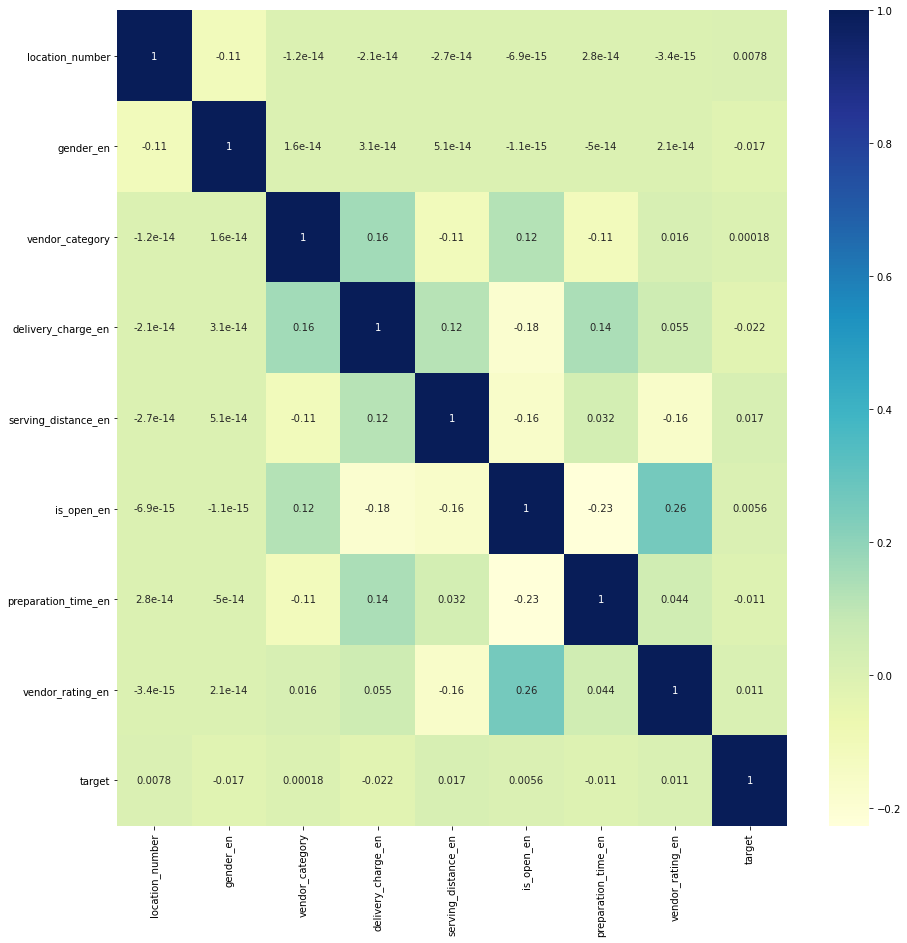

In [ ]:
#reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr.corr(), cmap="YlGnBu", annot=True)

### F. Feature Importance and Feature Elimination

In [ ]:
feature_x=train_df[['location_number','gender_en','latitude_x',\
           'longitude_x','id','latitude_y','longitude_y','vendor_category','delivery_charge_en',\
           'serving_distance_en','is_open_en','preparation_time_en','vendor_rating_en']]
feature_y=train_df['target']

In [ ]:
#Reference: https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(feature_x,feature_y)
# display the relative importance of each attribute
print(model.feature_importances_)

[1.75726757e-02 9.51664361e-04 5.96583373e-01 3.68724196e-01
 3.40524530e-03 3.15009961e-03 3.24524415e-03 6.91920362e-04
 1.04077279e-03 9.28178275e-04 5.30188142e-04 1.30292444e-03
 1.87351811e-03]


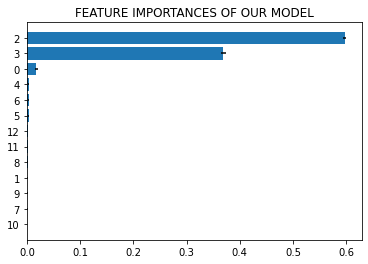

In [ ]:
#reference from : https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names

feature_imp = model.feature_importances_

std = np.std([x.feature_importances_ for x in model.estimators_],axis=0)
indices = np.argsort(feature_imp)

#plotting festure importances using plt
plt.figure()
plt.title("FEATURE IMPORTANCES OF OUR MODEL")

plt.barh(range(feature_x.shape[1]), feature_imp[indices], xerr=std[indices], align="center")
plt.yticks(range(feature_x.shape[1]), indices)
plt.ylim([-1, feature_x.shape[1]])
plt.show()

PLOT DESCRIPTION AND OBSERVATIONS:


---


1. Here the plot shows the features with their imprtance in predicting the target values.

2. It shows that Gender,Location (latitude and longitude), Location Number is very important features as already seen in EDA.


---





---



---



## 4.ENCODING TRAIN AND TEST 

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/CASE STUDY 1/train_full.csv')

In [ ]:
#taking only important columns
train_df=train[['gender','location_number','location_type','latitude_x',\
           'longitude_x','latitude_y','longitude_y','id','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating','target']]
print('-'*100)
print(train_df.shape)
train_df.head()

----------------------------------------------------------------------------------------------------
(5802400, 15)


gender  location_number location_type  ...  prepration_time  vendor_rating  target
0   Male                0          Work  ...               15            4.4       0
1   Male                0          Work  ...               14            4.7       0
2   Male                0          Work  ...               19            4.5       0
3   Male                0          Work  ...               16            4.5       0
4   Male                0          Work  ...               10            4.4       0

[5 rows x 15 columns]

In [ ]:
import math
#storing distance between points

dist=[]

for i in train_df.values:

  co_1 = (i[6]-i[4])**2
  co_2 = (i[7]-i[5])**2
    
  di=math.sqrt(co_1+co_2) 
  dist.append(di)

train_df['distance']=dist
print(train_df.shape)
print('-'*100)
train_df.head()

(5802400, 16)
----------------------------------------------------------------------------------------------------


gender  location_number location_type  ...  vendor_rating  target   distance
0   Male                0          Work  ...            4.4       0  68.109132
1   Male                0          Work  ...            4.7       0  69.267275
2   Male                0          Work  ...            4.5       0  70.846455
3   Male                0          Work  ...            4.5       0  71.930642
4   Male                0          Work  ...            4.4       0  73.128245

[5 rows x 16 columns]

In [ ]:
# label encoding the string data
from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
  
train_df['gender']= le.fit_transform(train_df['gender'].astype(str))
train_df['location_type']= le.fit_transform(train_df['location_type'].astype(str))
train_df['vendor_category_en']= le.fit_transform(train_df['vendor_category_en'].astype(str))

In [ ]:
train_df.to_csv('/content/drive/MyDrive/CASE STUDY 1/train_f.csv',index=False)

In [ ]:
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/CASE STUDY 1/train_f.csv')

In [ ]:
print(train.shape)
print('-'*100)
train.head()

(5802400, 16)
----------------------------------------------------------------------------------------------------


gender  location_number  location_type  ...  vendor_rating  target   distance
0       1                0              2  ...            4.4       0  68.109132
1       1                0              2  ...            4.7       0  69.267275
2       1                0              2  ...            4.5       0  70.846455
3       1                0              2  ...            4.5       0  71.930642
4       1                0              2  ...            4.4       0  73.128245

[5 rows x 16 columns]

### A. One hot encoding 

In [ ]:
#applyinh one-hot encoding to all the categorical data
gen = pd.get_dummies(train['gender'])
ltype = pd.get_dummies(train['location_type'])
venc = pd.get_dummies(train['vendor_category_en'])
dev = pd.get_dummies(train['delivery_charge'])
dis = pd.get_dummies(train['serving_distance'])
opn = pd.get_dummies(train['is_open'])
ptime = pd.get_dummies(train['prepration_time'])
rat = pd.get_dummies(train['vendor_rating'])

In [ ]:
final_train=pd.concat([train[['latitude_x','longitude_x','latitude_y','longitude_y','id','location_number','distance']],gen,ltype,venc,dev,dis,opn,ptime,rat,train['target']], axis=1)

In [ ]:
final_train.head()

latitude_x  longitude_x  latitude_y  longitude_y  ...  4.6  4.7  4.8  target
0      -96.44        -67.2     -0.5884       0.7544  ...    0    0    0       0
1      -96.44        -67.2     -0.4717       0.7446  ...    0    1    0       0
2      -96.44        -67.2     -0.4075       0.6436  ...    0    0    0       0
3      -96.44        -67.2     -0.5854       0.7540  ...    0    0    0       0
4      -96.44        -67.2      0.4807       0.5527  ...    0    0    0       0

[5 rows x 57 columns]

---

In [ ]:
#encoding the test files
test=pd.read_csv('/content/drive/MyDrive/CASE STUDY 1/test_full.csv')

In [ ]:
test.head()

customer_id gender  ...  id_obj  CID X LOC_NUM X VENDOR
0     ICE2DJP   Male  ...     4.0         ICE2DJP X 0 X 4
1     ICE2DJP   Male  ...    13.0        ICE2DJP X 0 X 13
2     ICE2DJP   Male  ...    20.0        ICE2DJP X 0 X 20
3     ICE2DJP   Male  ...    23.0        ICE2DJP X 0 X 23
4     ICE2DJP   Male  ...    28.0        ICE2DJP X 0 X 28

[5 rows x 72 columns]

In [ ]:
test_df=test[['gender','location_number','location_type','latitude_x',\
           'longitude_x','latitude_y','longitude_y','id','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating']]
print('-'*100)
print(test_df.shape)
test_df.head()

----------------------------------------------------------------------------------------------------
(1672000, 14)


gender  location_number  ... prepration_time  vendor_rating
0   Male              0.0  ...            15.0            4.4
1   Male              0.0  ...            14.0            4.7
2   Male              0.0  ...            19.0            4.5
3   Male              0.0  ...            16.0            4.5
4   Male              0.0  ...            10.0            4.4

[5 rows x 14 columns]

In [ ]:
import math
#storing distance between points

dist=[]

for i in test_df.values:

  co_1 = (i[5]-i[3])**2
  co_2 = (i[6]-i[4])**2
    
  di=math.sqrt(co_1+co_2) 
  dist.append(di)

test_df['distance']=dist
print(test_df.shape)
print('-'*100)
test_df.head()

(1672000, 15)
----------------------------------------------------------------------------------------------------


gender  location_number  ... vendor_rating    distance
0   Male              0.0  ...           4.4  117.496084
1   Male              0.0  ...           4.7  117.585642
2   Male              0.0  ...           4.5  117.579739
3   Male              0.0  ...           4.5  117.498300
4   Male              0.0  ...           4.4  118.254177

[5 rows x 15 columns]

In [ ]:
# label encoding the string data
from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
  
test_df['gender']= le.fit_transform(test_df['gender'].astype(str))
test_df['location_type']= le.fit_transform(test_df['location_type'].astype(str))
test_df['vendor_category_en']= le.fit_transform(test_df['vendor_category_en'].astype(str))

In [ ]:
test_df.to_csv('/content/drive/MyDrive/CASE STUDY 1/test_f.csv',index=False)

In [ ]:
import pandas as pd
test=pd.read_csv('/content/drive/MyDrive/CASE STUDY 1/test_f.csv')

In [ ]:
print(test.shape)
print('-'*100)
test.head()

(1672000, 15)
----------------------------------------------------------------------------------------------------


gender  location_number  ...  vendor_rating    distance
0       1              0.0  ...            4.4  117.496084
1       1              0.0  ...            4.7  117.585642
2       1              0.0  ...            4.5  117.579739
3       1              0.0  ...            4.5  117.498300
4       1              0.0  ...            4.4  118.254177

[5 rows x 15 columns]

In [ ]:
gen = pd.get_dummies(test['gender'])
ltype = pd.get_dummies(test['location_type'])
venc = pd.get_dummies(test['vendor_category_en'])
dev = pd.get_dummies(test['delivery_charge'])
dis = pd.get_dummies(test['serving_distance'])
opn = pd.get_dummies(test['is_open'])
ptime = pd.get_dummies(test['prepration_time'])
rat = pd.get_dummies(test['vendor_rating'])

In [ ]:
final_test=pd.concat([test[['latitude_x','longitude_x','latitude_y','longitude_y','id','location_number','distance']],gen,ltype,venc,dev,dis,opn,ptime,rat],axis=1)

In [ ]:
final_test.head()

latitude_x  longitude_x  latitude_y  longitude_y  ...  4.5  4.6  4.7  4.8
0      -96.44        -67.2     -0.5884       0.7544  ...    0    0    0    0
1      -96.44        -67.2     -0.4717       0.7446  ...    0    0    1    0
2      -96.44        -67.2     -0.4075       0.6436  ...    1    0    0    0
3      -96.44        -67.2     -0.5854       0.7540  ...    1    0    0    0
4      -96.44        -67.2      0.4807       0.5527  ...    0    0    0    0

[5 rows x 57 columns]

## 5.MODELLING


In [24]:
!pip install xgboost

In [25]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [26]:
import pandas as pd
train=pd.read_csv('train_data.csv')
test=pd.read_csv('test_data.csv')

In [27]:
data=train.copy()
data.head()

latitude_x  longitude_x  latitude_y  longitude_y  id  location_number  \
0      -96.44        -67.2     -0.5884       0.7544   4                0   
1      -96.44        -67.2     -0.4717       0.7446  13                0   
2      -96.44        -67.2     -0.4075       0.6436  20                0   
3      -96.44        -67.2     -0.5854       0.7540  23                0   
4      -96.44        -67.2      0.4807       0.5527  28                0   

    distance  0  1  2  ...  4.0  4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  \
0  68.109132  0  1  0  ...    0    0    0    0    1    0    0    0    0   
1  69.267275  0  1  0  ...    0    0    0    0    0    0    0    1    0   
2  70.846455  0  1  0  ...    0    0    0    0    0    1    0    0    0   
3  71.930642  0  1  0  ...    0    0    0    0    0    1    0    0    0   
4  73.128245  0  1  0  ...    0    0    0    0    1    0    0    0    0   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 57 columns]

In [28]:
#creating data for training and target

y=data['target'] #target

data.drop(['target'],inplace=True,axis=1)
X=data #dataset

X=X.fillna(0) #filling null values
print('-'*100)
print(X.shape,y.shape)

----------------------------------------------------------------------------------------------------
(5802400, 56) (5802400,)




---





---



#### A. LINEAR REGRESSION 

In [ ]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

print('-'*100)
print(X.shape,y.shape)
print('-'*100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

lnr = LinearRegression()
lnr.fit(X_train, y_train)

----------------------------------------------------------------------------------------------------
(5802400, 56) (5802400,)
----------------------------------------------------------------------------------------------------


LinearRegression()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#predicting the outputs

y_pred=lnr.predict(X_test)
y_predict=[]

for i in y_pred: #round off values for target data
  if i<=0.5:
    y_predict.append(0)
  else:
    y_predict.append(1)

arr=confusion_matrix(y_test, y_predict)

print('Accuracy Score: ',accuracy_score(y_test, y_predict))
print('-'*100)
print('Precision: ',precision_score(y_test, y_predict))
print('-'*100)
print('Recall: ',recall_score(y_test, y_predict))
print('-'*100)

f1=(2*(precision_score(y_test, y_predict))*(recall_score(y_test, y_predict)))/((recall_score(y_test, y_predict))+(precision_score(y_test, y_predict)))
print('The F1 score:',f1)

Accuracy Score:  0.9864805942368675
----------------------------------------------------------------------------------------------------
Precision:  0.0
----------------------------------------------------------------------------------------------------
Recall:  0.0
----------------------------------------------------------------------------------------------------
The F1 score: nan




---



#### B. LOGISTIC REGRESSION

In [ ]:
#reference from malware assignment and previous assignments
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33)


alpha = [10 ** x for x in range(-3, 3)]
log_error=[]

#below code hypertune the parameters and do calliberations
#the code structure is referenced from the malware assignment code

for i in alpha: #hyperparameter ALpha tuning
    lor=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    
    lor.fit(X_train,y_train)
    clf = CalibratedClassifierCV(lor,method="sigmoid") #caliberation used
    
    clf.fit(X_train, y_train)
    predict= clf.predict_proba(X_cv)
    log_error.append(log_loss(y_cv, predict, labels=lor.classes_, eps=1e-15)) #printing log error for tuning
    
for i in range(len(log_error)):
    print ('Log_loss for C = ',alpha[i],'is',log_error[i])

best_alpha = np.argmin(log_error) #choosing best alpha
#---------------------------------------------------------------------------------    

fig, ax = plt.subplots()
ax.plot(alpha, log_error,c='g')

for i, txt in enumerate(np.round(log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

Log_loss for C =  0.001 is 0.07082647096390168
Log_loss for C =  0.01 is 0.07082647096390168
Log_loss for C =  0.1 is 0.07082647096390168
Log_loss for C =  1 is 0.07082647096390168
Log_loss for C =  10 is 0.07082647096390168
Log_loss for C =  100 is 0.07082647096390168


<IPython.core.display.Javascript object>

In [ ]:
#Applying hyper-tuned parameter for test data

logistic=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')

#getting final model ready
logistic.fit(X_train,y_train)
clf = CalibratedClassifierCV(logistic, method="sigmoid")
clf.fit(X_train, y_train)

#predicting for F1 score,Precision and Recall
pred=clf.predict(X_test) 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_predict=[]

for i in pred: #round off values for target data
  if i<=0.5:
    y_predict.append(0)
  else:
    y_predict.append(1)

#printing metrics
print('Accuracy Score: ',accuracy_score(y_test, y_predict))
print('-'*100)
print('Precision: ',precision_score(y_test, y_predict))
print('-'*100)
print('Recall: ',recall_score(y_test, y_predict))
print('-'*100)

f1=(2*(precision_score(y_test, y_predict))*(recall_score(y_test, y_predict)))/((recall_score(y_test, y_predict))+(precision_score(y_test, y_predict)))
print('The F1 score:',f1)

Accuracy Score:  0.9864211360816214
----------------------------------------------------------------------------------------------------
Precision:  0.0
----------------------------------------------------------------------------------------------------
Recall:  0.0
----------------------------------------------------------------------------------------------------
The F1 score: nan


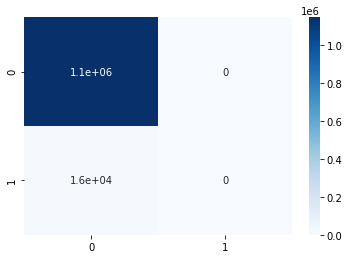

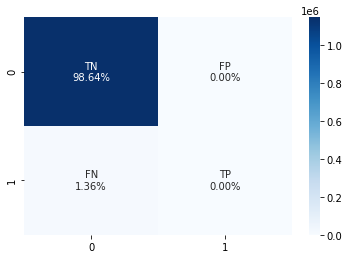

In [ ]:
#reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(arr, annot=True, cmap='Blues')
plt.show()

gnames = ['TN','FP','FN','TP'] #labeling the map
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))] #calculation of percentage of positives and negative

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)] #mapping labels with their percentages
labels = np.asarray(labels).reshape(2,2) #reshaping the matrix

sns.heatmap(arr, annot=labels, fmt='', cmap='Blues')#printing the confusion m



---



#### C. RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.4)

In [ ]:
alpha=[10,50,100,300]
cvlog_error=[]
trlog_error=[]

#below code hypertune the parameters and do calliberations
#the code structure is referenced from the malware assignment code
for i in alpha:

    clf=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    clf.fit(X_train,y_train)

    clf1 = CalibratedClassifierCV(clf, method="sigmoid")
    clf1.fit(X_train, y_train)
    pred = clf1.predict_proba(X_cv)
    cvlog_error.append(log_loss(y_cv, pred, labels=clf.classes_, eps=1e-15))

Log_loss for n_estimator =  10 is 0.06728679878785393
Log_loss for n_estimator =  50 is 0.06712139179425688
Log_loss for n_estimator =  100 is 0.06710234680562388
Log_loss for n_estimator =  300 is 0.06708891062571232


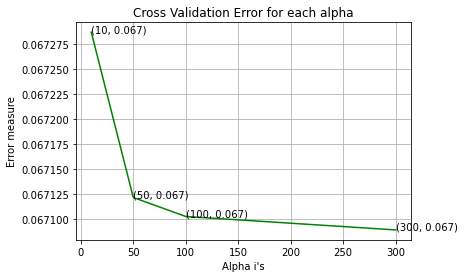

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

for i in range(len(cvlog_error)):
    print ('Log_loss for n_estimator = ',alpha[i],'is',cvlog_error[i])


best_alpha = np.argmin(cvlog_error)

fig, ax = plt.subplots()
ax.plot(alpha, cvlog_error,c='g')

for i, txt in enumerate(np.round(cvlog_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cvlog_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
clf=RandomForestClassifier(n_estimators=10,random_state=42,n_jobs=-1)
clf.fit(X_train,y_train)

#making final model ready
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

pred = cal_clf.predict_proba(X_train)


In [ ]:
print('For values of best alpha = ', 10, "The train log loss is:",log_loss(y_train, pred))

pred = cal_clf.predict_proba(X_cv)
print('For values of best alpha = ', 10, "The cross validation log loss is:",log_loss(y_cv, pred))

pred = cal_clf.predict_proba(X_test)
print('For values of best alpha = ', 10, "The test log loss is:",log_loss(y_test, pred))

For values of best alpha =  10 The train log loss is: 0.035592052103006686
For values of best alpha =  10 The cross validation log loss is: 0.06647353701649197
For values of best alpha =  10 The test log loss is: 0.06599998051399218


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict=cal_clf.predict(X_test)

#printing metrics
print('Accuracy Score: ',accuracy_score(y_test, predict))
print('-'*100)
print('Precision: ',precision_score(y_test, predict))
prec=precision_score(y_test, predict)
print('-'*100)
print('Recall: ',recall_score(y_test, predict))
rec=recall_score(y_test, predict)
print('-'*100)

f1=(2*prec*rec)/(rec+prec+0.00001)
print('The F1 score:',f1)

Accuracy Score:  0.9866016648283469
----------------------------------------------------------------------------------------------------
Precision:  0.5333333333333333
----------------------------------------------------------------------------------------------------
Recall:  0.0012860909266285126
----------------------------------------------------------------------------------------------------
The F1 score: 0.002565946166610598


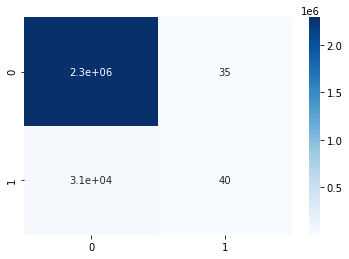

<AxesSubplot:>

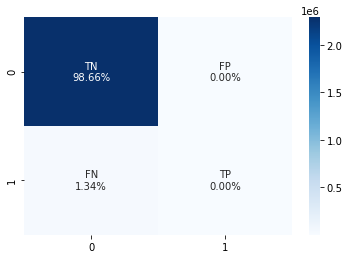

In [ ]:
#reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

arr=confusion_matrix(y_test, predict)

sns.heatmap(arr, annot=True, cmap='Blues')
plt.show()

gnames = ['TN','FP','FN','TP'] #labeling the map
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))] #calculation of percentage of positives and negative

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)] #mapping labels with their percentages
labels = np.asarray(labels).reshape(2,2) #reshaping the matrix

sns.heatmap(arr, annot=labels, fmt='', cmap='Blues')#printing the confusion m



---







#### D. XGBOOST

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.4)

In [ ]:
alpha=[10,50,100,200]

cvlog_error=[]

#below code hypertune the parameters and do calliberations
#the code structure is referenced from the malware assignment code
for i in alpha:
    print('Alpha:',i)
    clf=XGBClassifier(n_estimators=i,nthread=-1)
    clf.fit(X_train,y_train)
    
    xg_clf = CalibratedClassifierCV(clf, method="sigmoid")
    xg_clf.fit(X_train, y_train)
    pred = xg_clf.predict_proba(X_cv)
    cvlog_error.append(log_loss(y_cv, pred, labels=clf.classes_, eps=1e-15))

for i in range(len(cvlog_error)):
    print ('log_loss for c = ',alpha[i],'is',cvlog_error[i])

best_alpha = np.argmin(cvlog_error)

Alpha: 10
[14:04:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

In [ ]:
clf=XGBClassifier(n_estimators=200,nthread=-1)
clf.fit(X_train,y_train)
xg_clf = CalibratedClassifierCV(clf, method="sigmoid")
xg_clf.fit(X_train, y_train)    

In [ ]:
predict_y = xg_clf.predict_proba(X_train)
print('For values of best alpha = ', 200, "The train log loss is:",log_loss(y_train, predict_y))

predict_y = xg_clf.predict_proba(X_cv)
print('For values of best alpha = ',  200, "The cross validation log loss is:",log_loss(y_cv, predict_y))

predict_y = xg_clf.predict_proba(X_test)
print('For values of best alpha = ',  200, "The test log loss is:",log_loss(y_test, predict_y))

For values of best alpha =  200 The train log loss is: 0.05632387345126351
For values of best alpha =  200 The cross validation log loss is: 0.059854845863674525
For values of best alpha =  200 The test log loss is: 0.060016433206268614


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict=xg_clf.predict(X_test)
#printing metrics

print('Accuracy Score: ',accuracy_score(y_test, predict))
print('-'*100)
print('Precision: ',precision_score(y_test, predict))
prec=precision_score(y_test, predict)
print('-'*100)
print('Recall: ',recall_score(y_test, predict))
rec=recall_score(y_test, predict)
print('-'*100)

f1=(2*prec*rec)/(rec+prec+0.00000001)
print('The F1 score:',f1)

Accuracy Score:  0.9861514201020267
----------------------------------------------------------------------------------------------------
Precision:  0.403125
----------------------------------------------------------------------------------------------------
Recall:  0.05351672198110799
----------------------------------------------------------------------------------------------------
The F1 score: 0.09448951787668285


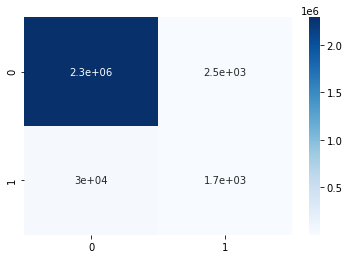

<AxesSubplot:>

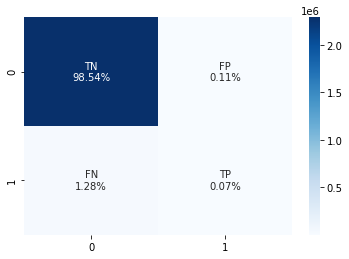

In [ ]:
#reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

arr=confusion_matrix(y_test, predict)

sns.heatmap(arr, annot=True, cmap='Blues')
plt.show()

gnames = ['TN','FP','FN','TP'] #labeling the map
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))] #calculation of percentage of positives and negative

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)] #mapping labels with their percentages
labels = np.asarray(labels).reshape(2,2) #reshaping the matrix

sns.heatmap(arr, annot=labels, fmt='', cmap='Blues')#printing the confusion m

---

### E. XGBOOST WITH RANDOM SEARCH 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.4)

In [ ]:
xg_=XGBClassifier(n_estimators=200, learning_rate=0.05, colsample_bytree=1, max_depth=3)
xg_.fit(X_train,y_train)

xg=CalibratedClassifierCV(xg_,method='sigmoid')
xg.fit(X_train,y_train)
#below code hypertune the parameters and do calliberations
#the code structure is referenced from the malware assignment code

predict_y = xg.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))

predict_y = xg.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))

predict_y = xg.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

[15:28:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:31:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:33:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict=xg.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, predict))
print('-'*100)
print('Precision: ',precision_score(y_test, predict))
prec=precision_score(y_test, predict)
print('-'*100)
print('Recall: ',recall_score(y_test, predict))
rec=recall_score(y_test, predict)
print('-'*100)

f1=(2*prec*rec)/(rec+prec+0.00001)
print('The F1 score:',f1)

Accuracy Score:  0.9860820522542396
----------------------------------------------------------------------------------------------------
Precision:  0.3217324052590874
----------------------------------------------------------------------------------------------------
Recall:  0.026512858098849623
----------------------------------------------------------------------------------------------------
The F1 score: 0.0489873176599693


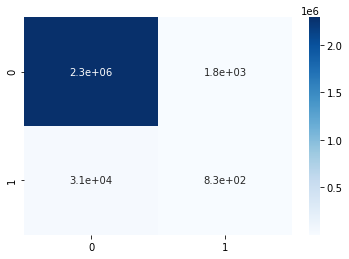

<AxesSubplot:>

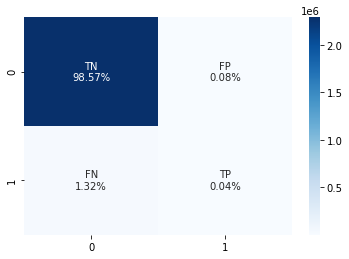

In [ ]:
#reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

arr=confusion_matrix(y_test, predict)

sns.heatmap(arr, annot=True, cmap='Blues')
plt.show()

gnames = ['TN','FP','FN','TP'] #labeling the map
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))] #calculation of percentage of positives and negative

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)] #mapping labels with their percentages
labels = np.asarray(labels).reshape(2,2) #reshaping the matrix

sns.heatmap(arr, annot=labels, fmt='', cmap='Blues')#printing the confusion m

### F. USING SMOTE FOR IMBALANCED DATASET </h2>

In [9]:
!pip install imbalanced-learn
#the data is highly imbalanced, we have to balance it using smote module

     |████████████████████████████████| 206 kB 5.2 MB/s eta 0:00:01


In [11]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

#printing the counter fucntion to get frequency of classes
counter = Counter(y)
print(counter)

Counter({0: 5724146, 1: 78254})


In [12]:
over = SMOTE(sampling_strategy=0.4)
X,y=over.fit_resample(X, y)

#oversampling the lower data 

In [13]:
counter = Counter(y)
print(counter)

Counter({0: 5724146, 1: 2289658})


In [14]:
under = RandomUnderSampler(sampling_strategy=0.6)
X,y=under.fit_resample(X,y)
counter = Counter(y)
#undersampling the upper data
print(counter)

Counter({0: 3816096, 1: 2289658})


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train, test_size = 0.33)

In [16]:
xg_=XGBClassifier(n_estimators=250, learning_rate=0.05, colsample_bytree=1, max_depth=3)
xg_.fit(X_train,y_train)

#below code hypertune the parameters and do calliberations
#the code structure is referenced from the malware assignment code

xg=CalibratedClassifierCV(xg_,method='sigmoid')
xg.fit(X_train,y_train)

predict_y = xg.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))

predict_y = xg.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))

predict_y = xg.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

[08:19:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:31:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict=xg.predict(X_test)

#printing metrics
print('Accuracy Score: ',accuracy_score(y_test, predict))
print('-'*100)
print('Precision: ',precision_score(y_test, predict))
prec=precision_score(y_test, predict)
print('-'*100)
print('Recall: ',recall_score(y_test, predict))
rec=recall_score(y_test, predict)
print('-'*100)

f1=(2*prec*rec)/(rec+prec+0.000000000000001)
print('The F1 score:',f1)

Accuracy Score:  0.78724541527888
----------------------------------------------------------------------------------------------------
Precision:  0.741192875798669
----------------------------------------------------------------------------------------------------
Recall:  0.6647798334275206
----------------------------------------------------------------------------------------------------
The F1 score: 0.7009098729694254


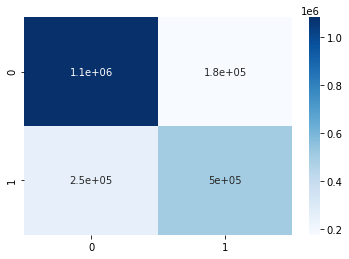

<AxesSubplot:>

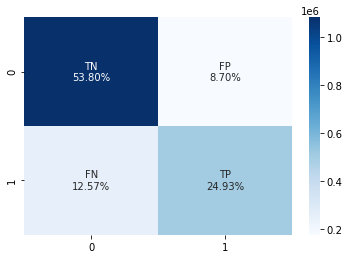

In [18]:
#reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

arr=confusion_matrix(y_test, predict)

sns.heatmap(arr, annot=True, cmap='Blues')
plt.show()

gnames = ['TN','FP','FN','TP'] #labeling the map
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))] #calculation of percentage of positives and negative

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)] #mapping labels with their percentages
labels = np.asarray(labels).reshape(2,2) #reshaping the matrix

sns.heatmap(arr, annot=labels, fmt='', cmap='Blues')#printing the confusion m



---



---



## 6.STORING THE MODELS AND VARIABLES

In [23]:
import pickle
#finally I am storing the model in a pickle file
  
pickle.dump(xg, open('/home/abhishek_croblaze/model.pkl', 'wb'))



---

---



---



